In [1]:
#!/usr/bin/env python
# coding: utf-8

%load_ext autoreload
%autoreload 2



import torch, datetime, click
torch.set_default_tensor_type(torch.cuda.FloatTensor)

import swyft
from utils import *
from data_mgmt import get_paths, get_ids

from plot import *

In [2]:
DEVICE = 'cuda'



m = 1
nsub = 1
nsim = 1000

nmc = 1
sigma = 0.0

lr = 1e-3
factor = 1e-1
patience = 5
max_epochs = 10

zero = 'toy'

In [3]:
time_start = datetime.datetime.now()

def noise(obs, _= None, sigma_n = sigma):
    image = obs["image"]
    eps = np.random.randn(*image.shape) * sigma_n
    return {"image": image + eps}

# Set definitions (should go to click)
systemname = "ngc4414"

# Set utilities

store_path, dataset_path, mre_path, _ = get_paths(dict(m=m,nsub=nsub,nsim=nsim,nmc=nmc,sigma=sigma,zero=zero))

store = swyft.Store.load(path=store_path)
print(f'Store has {len(store)} simulations.')

torch.set_default_tensor_type(torch.cuda.FloatTensor)  # HACK
config = get_config(systemname, str(nsub), str(m))
torch.set_default_tensor_type(torch.FloatTensor)

prior, n_pars, lows, highs = get_prior(config)
L = config.kwargs["defs"]["nx"]
print(f'Image has L = {L}.')

dataset = swyft.Dataset(nsim, prior, store, simhook = noise)


Loading existing store.
Store has 963 simulations.
Image has L = 40.


Training ../data/mre/mre_toy_m_1_nsub_1_nsim_1000_sigma_0.0_nmc_1.pt!


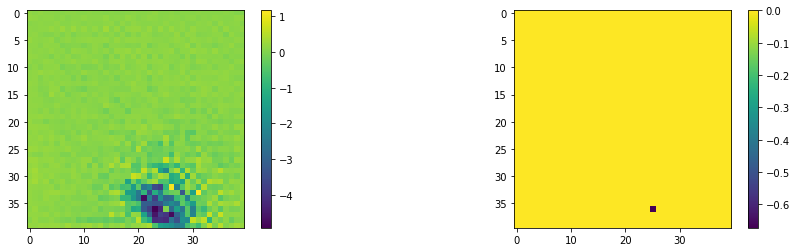

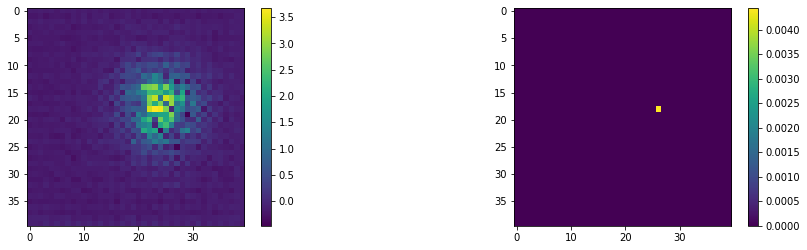

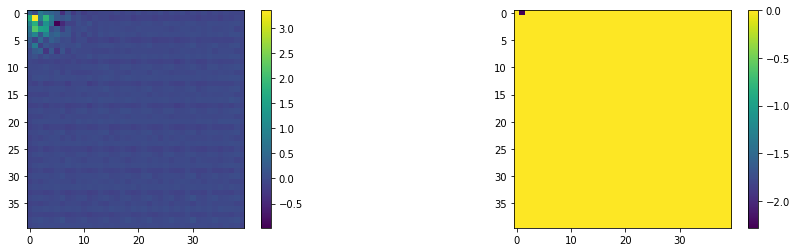

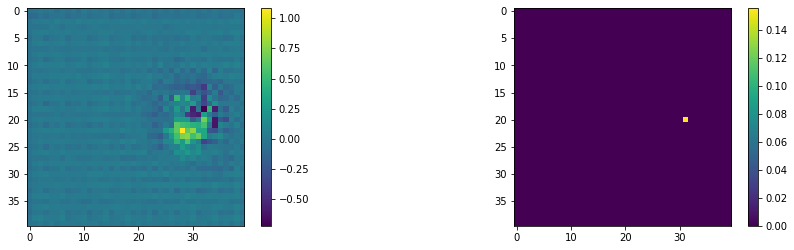

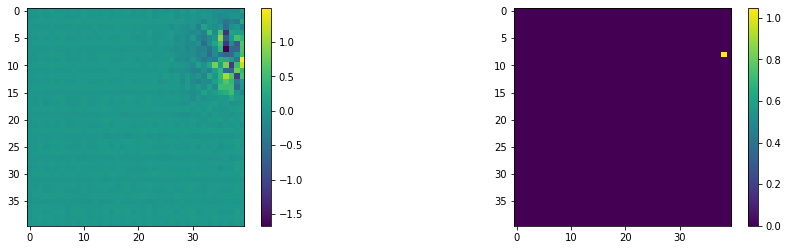

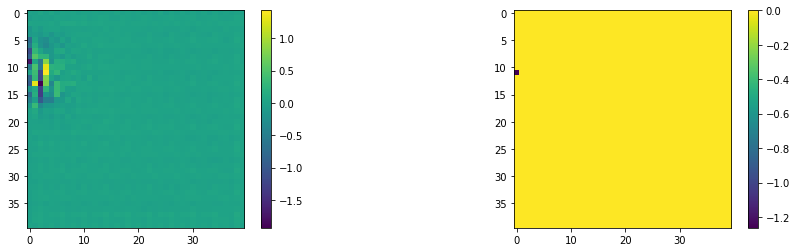

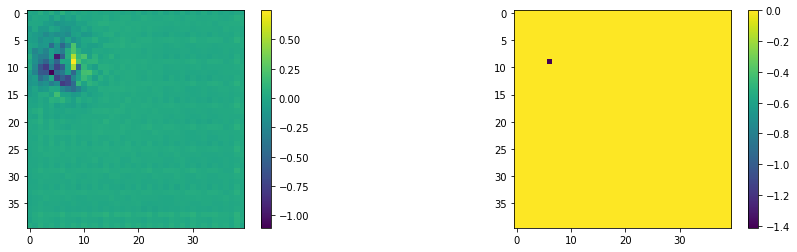

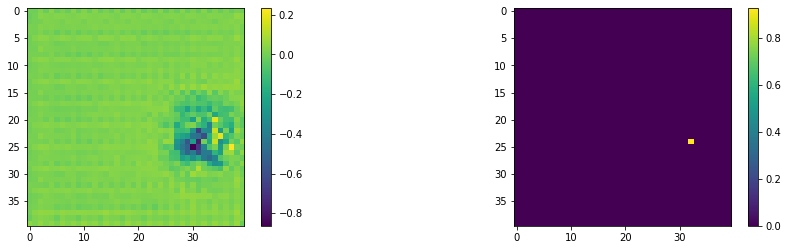

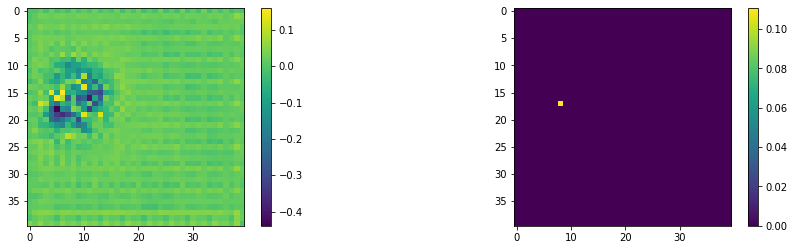

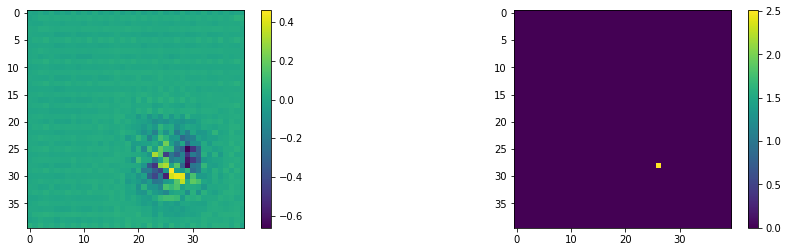

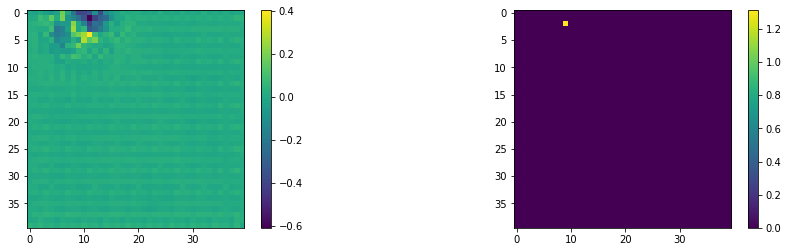

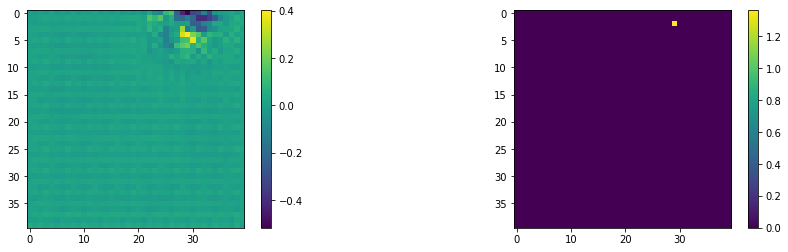

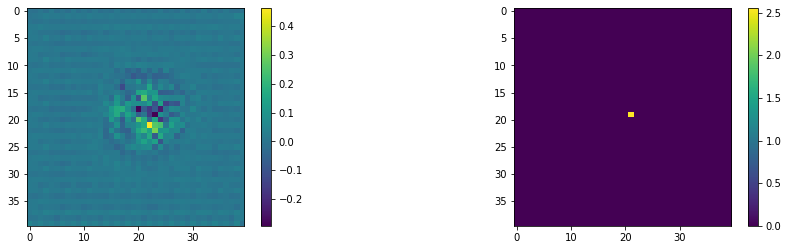

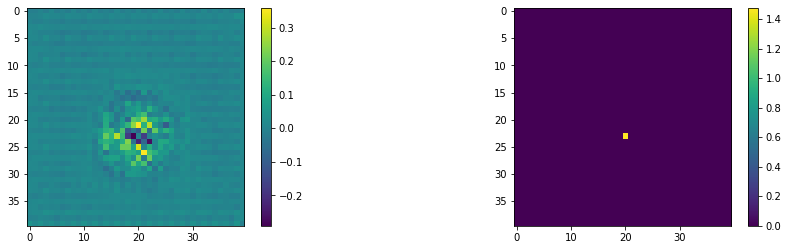

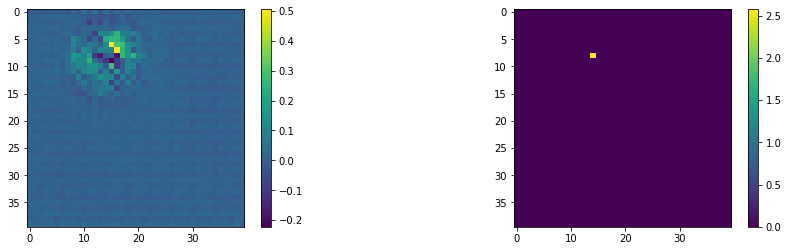

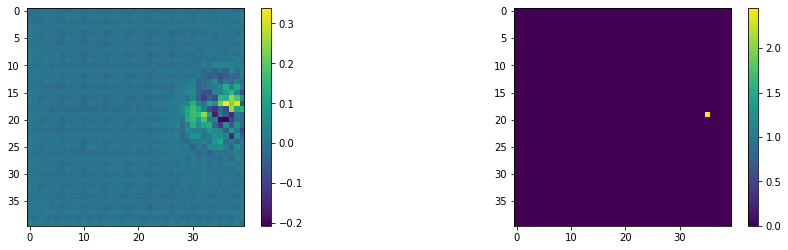

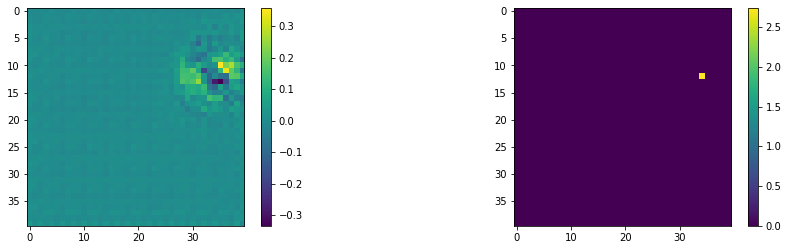

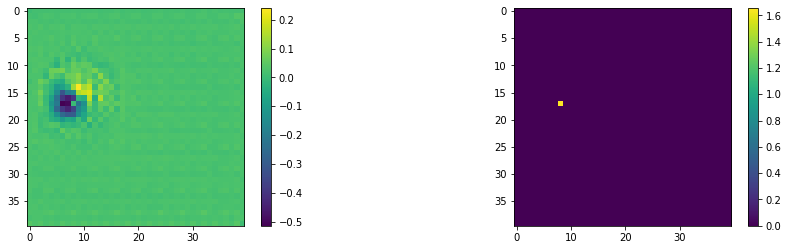

training: lr=0.0005, epoch=1, validation loss=4436.587891

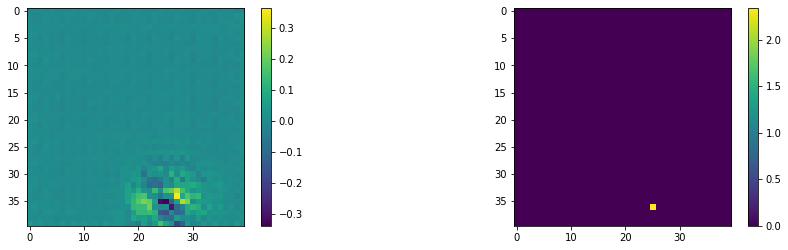

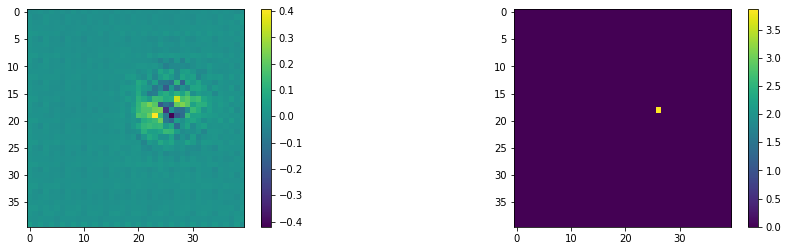

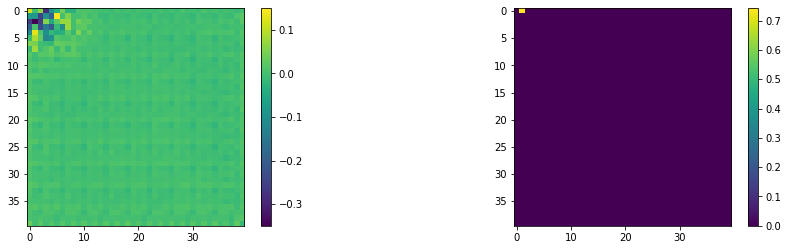

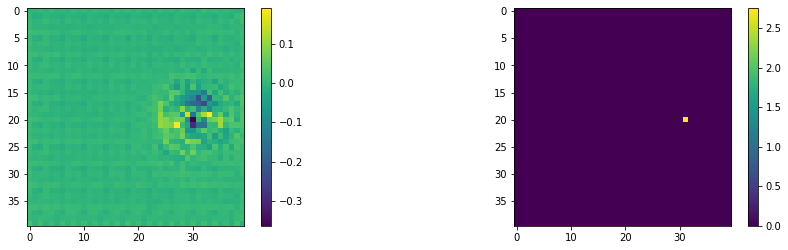

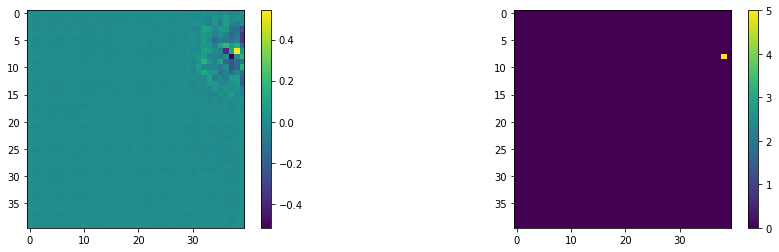

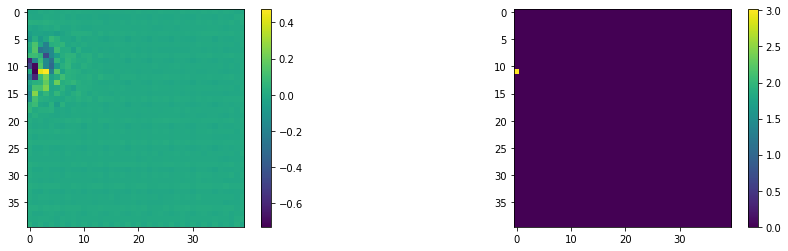

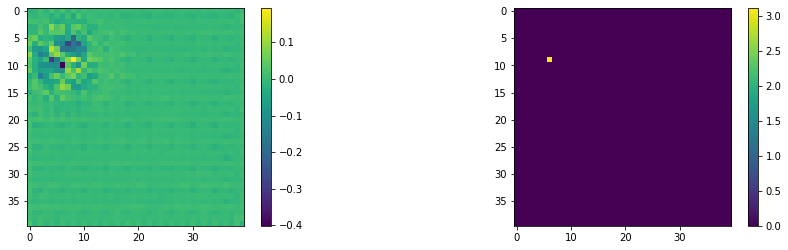

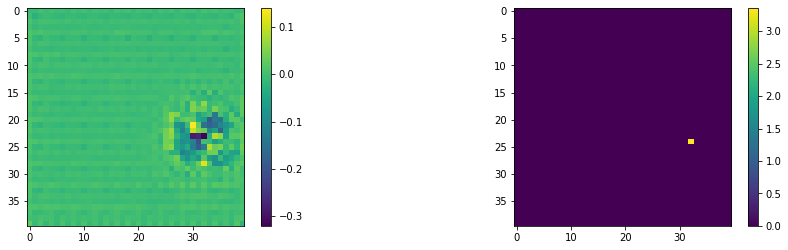

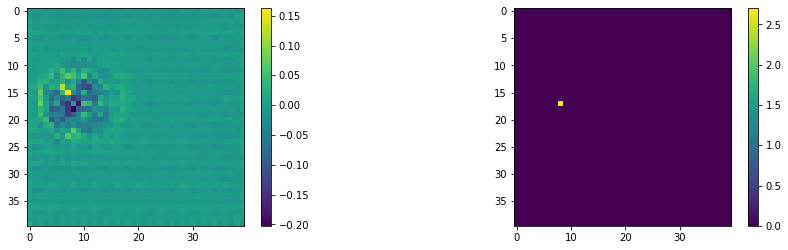

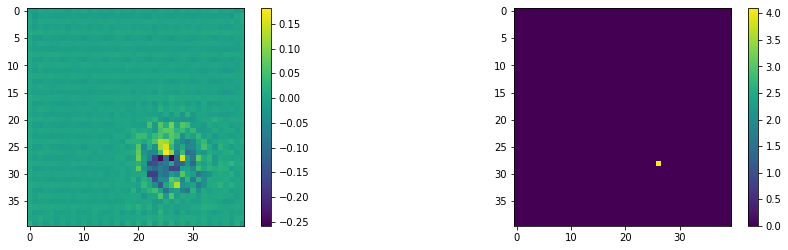

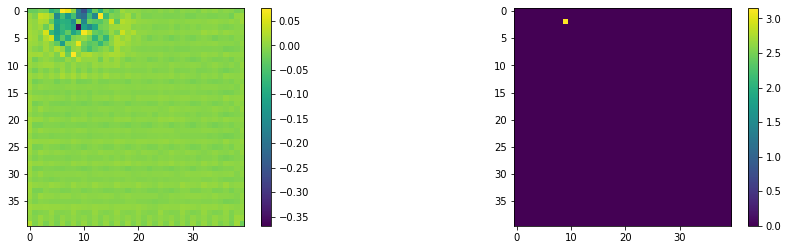

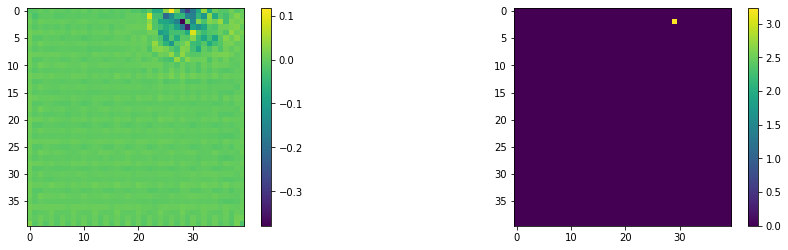

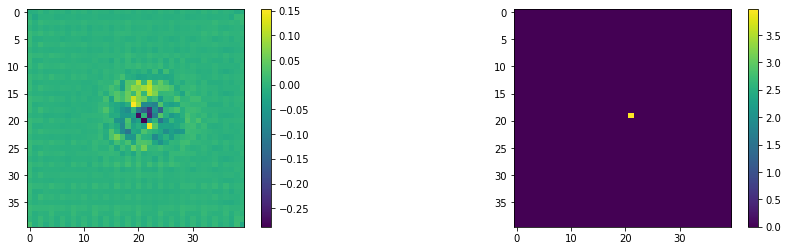

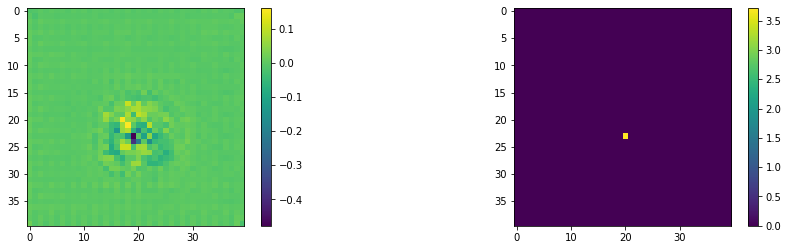

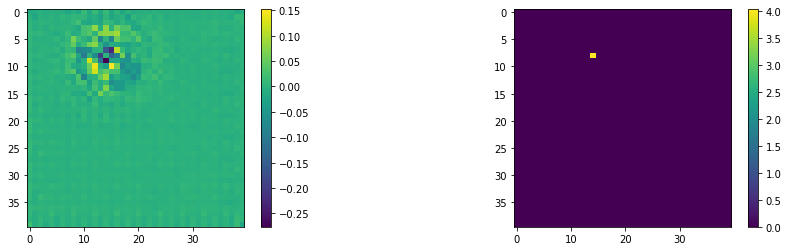

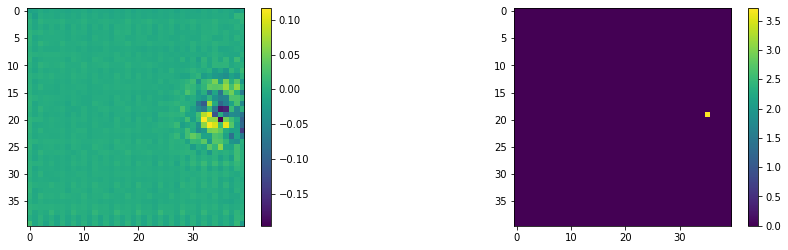

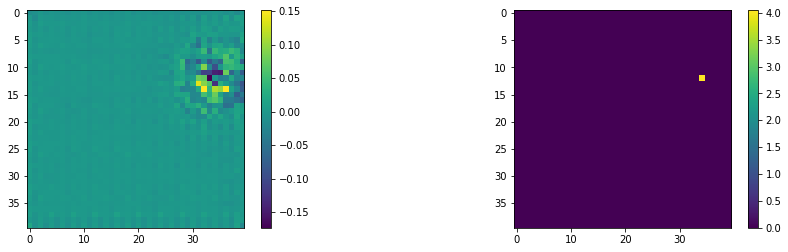

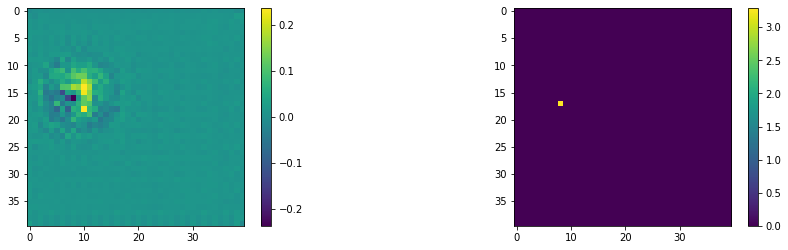

training: lr=0.0005, epoch=2, validation loss=4435.668945

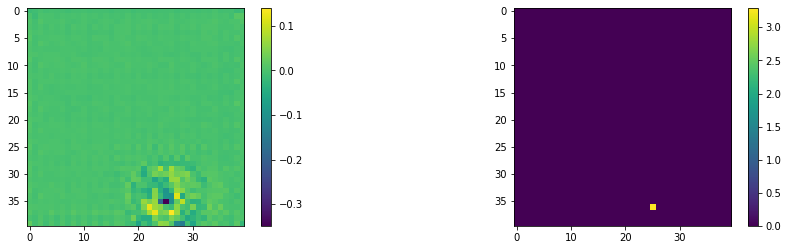

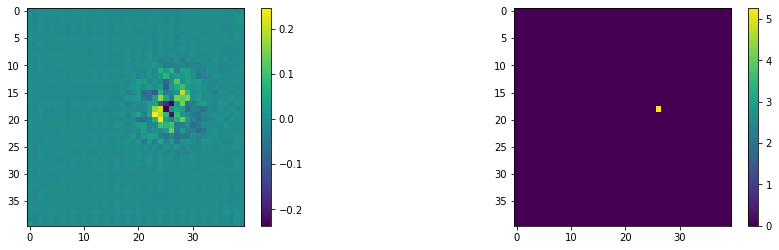

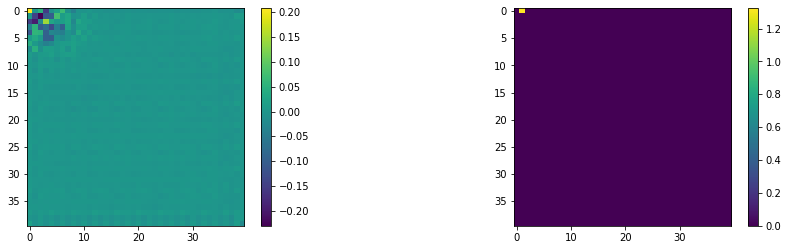

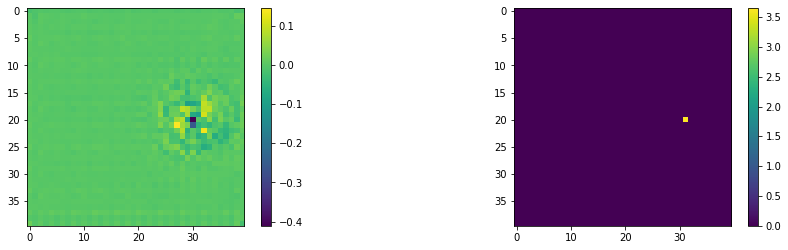

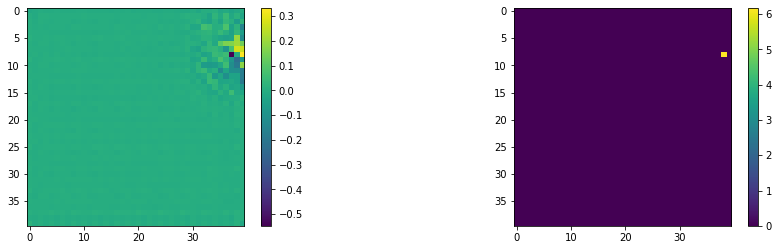

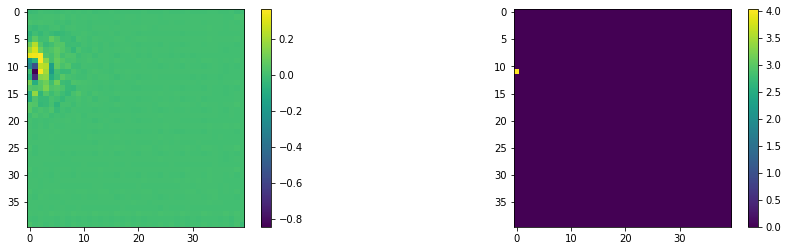

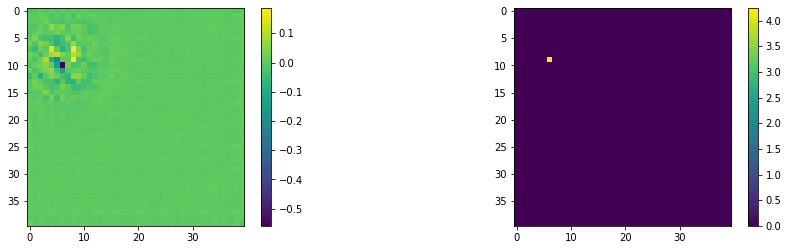

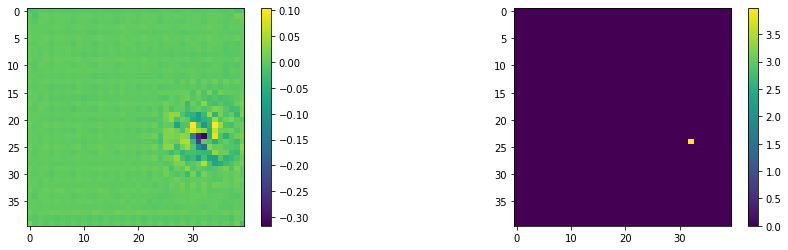

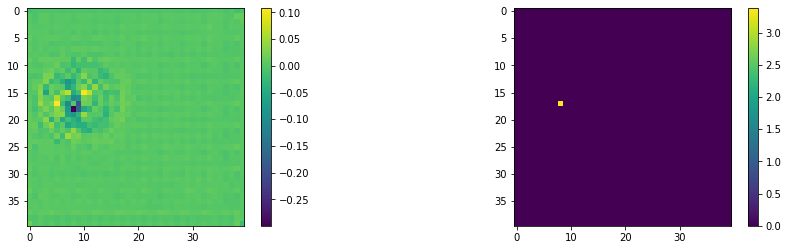

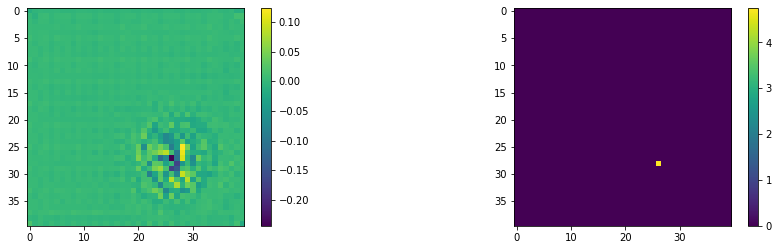

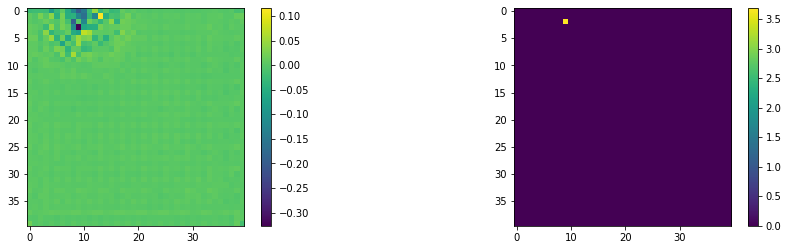

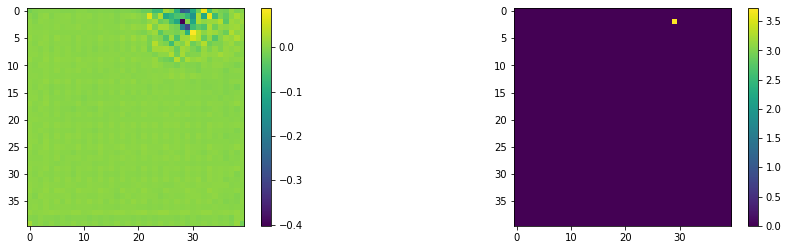

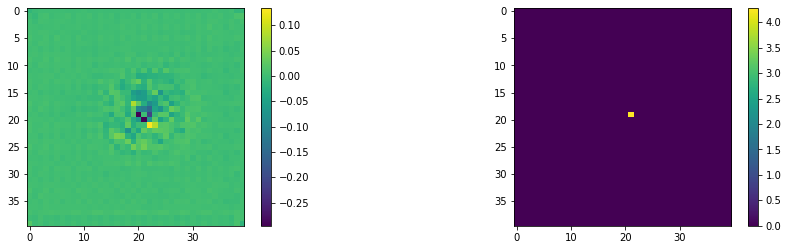

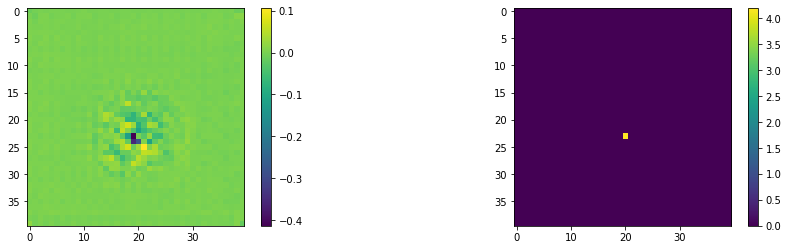

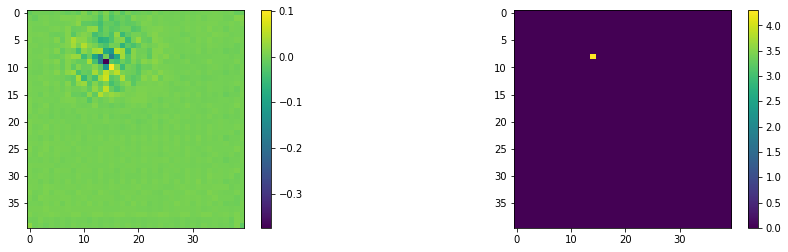

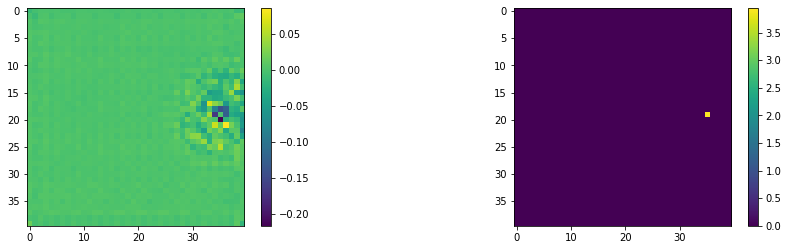

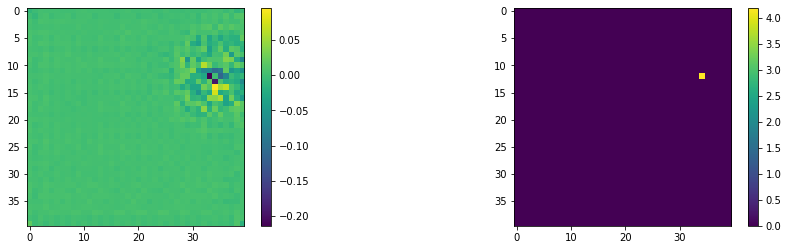

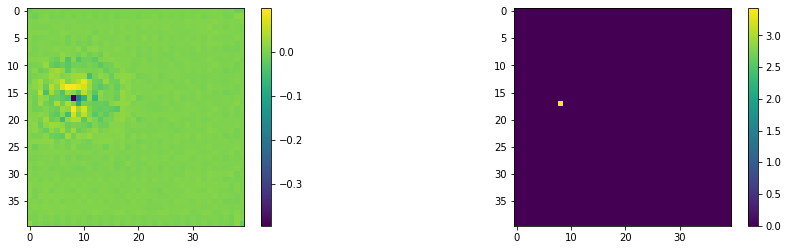

training: lr=0.0005, epoch=3, validation loss=4435.333008

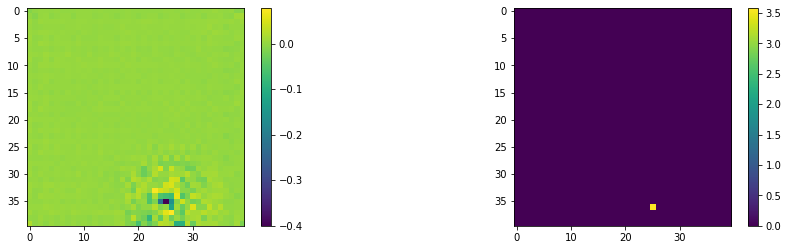

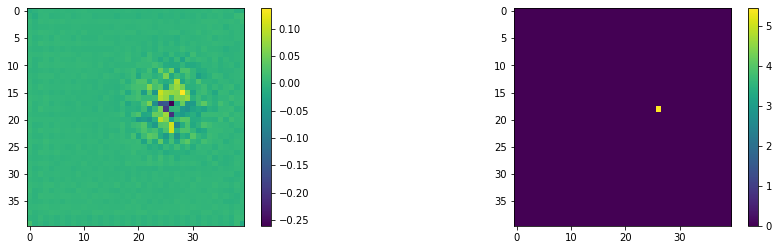

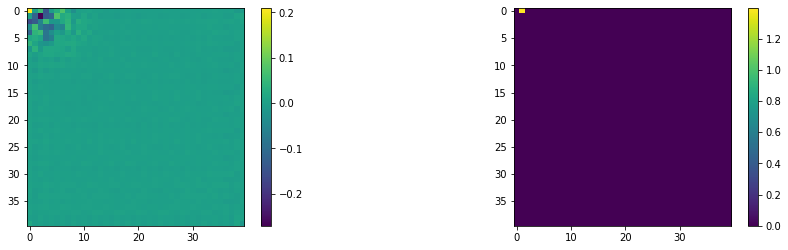

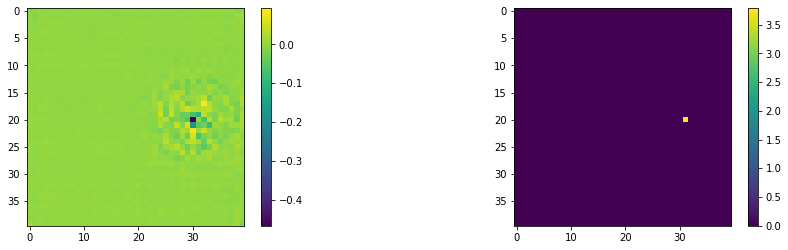

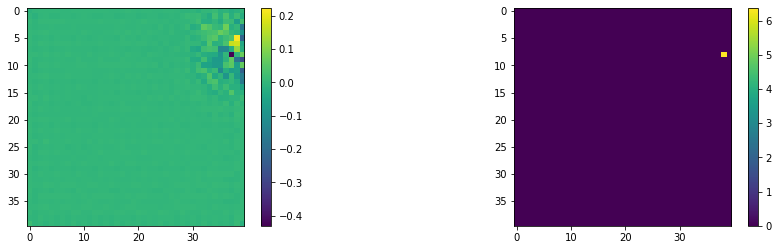

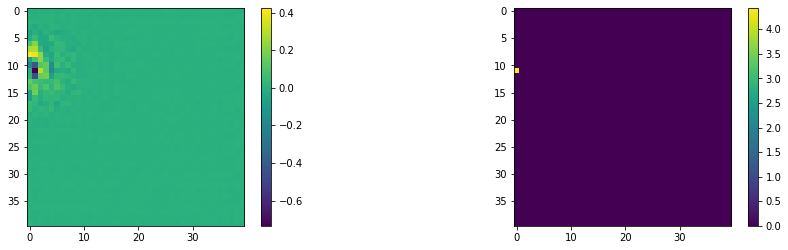

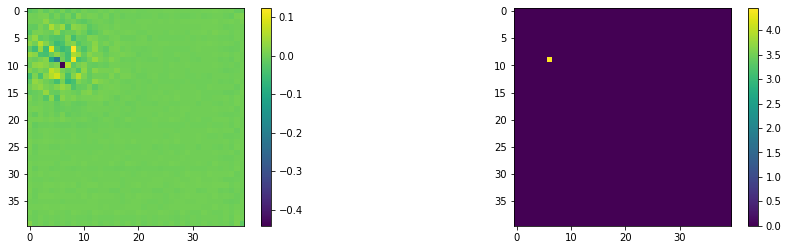

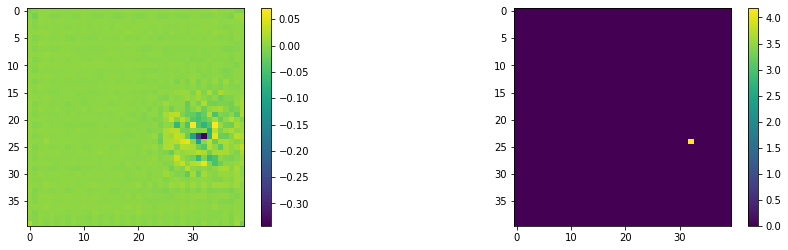

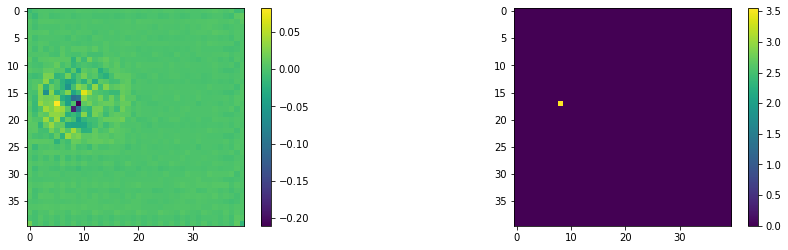

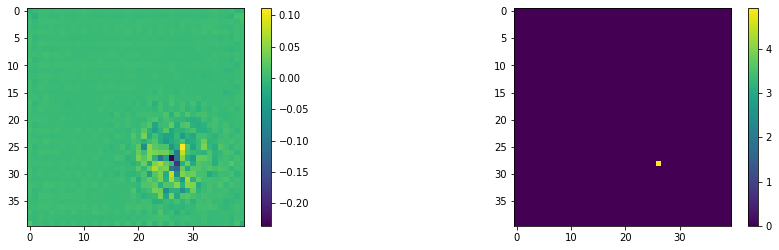

KeyboardInterrupt: 

In [11]:

    
class CustomParameterTransform(torch.nn.Module):
    def __init__(self, nmbins: int, L, lows, highs) -> None:
        super().__init__()
        self.nmbins = nmbins
        self.L   = L
        self.lows = lows
        self.highs = highs
        
    def v_to_grid(self, coord_v):
              
        coorv_v10 = torch.clone(coord_v)
        
        # Transform all masses from e.g. 10^8.5 to 8.5 so they are aligned with the highs and lows
        coorv_v10[:,2::3] = torch.log10(coorv_v10[:,2::3])
        
        n = len(coord_v[0])/3
        assert n.is_integer()
        n = int(n)
          
        lows = np.full(coord_v.shape, np.tile(self.lows, n))
        highs = np.full(coord_v.shape, np.tile(self.highs, n))   
        
        grid = lambda v: (v - lows) / (highs - lows)
        coord_grid = grid(coorv_v10)
        
        return coord_grid

    def forward(self, coord_v):       
        
#         print('coord_v', coord_v.shape)
         
        coord_grid = self.v_to_grid(coord_v)
        
        n_batch =  coord_grid.shape[0]
        n_coords = coord_grid.shape[1]*2/3
        assert n_coords.is_integer()

  
        z = torch.zeros((n_batch, self.nmbins, self.L, self.L), device = DEVICE)
  
        if not (n_batch == 0 or n_coords == 0):
            
            x_grid, y_grid, m_grid = coord_grid.view(-1,3).T.to(DEVICE)            

            x_i = torch.floor((x_grid * self.L).flatten()).type(torch.long) 
            y_i = torch.floor((y_grid * self.L).flatten()).type(torch.long) 
            m_i = torch.floor( m_grid * self.nmbins).type(torch.long) 
            b_i   = torch.floor(torch.arange(0, n_batch, 1/n_coords*2).to(DEVICE)).type(torch.long)
            
            indices = tuple(torch.stack((b_i, m_i, y_i, x_i)))
            z[indices] = 1
            
#         print('z', z.shape)
#         plt_imshow(z[:7:2].squeeze())
#         plt_imshow(z[1:8:2].squeeze())
#         plt_imshow(z[:12].squeeze(), 2)
#         return z #ABABCDCDEFEF # #
        return torch.cat((1-z, z), dim = 1)

class CustomMarginalClassifier(torch.nn.Module):
    def __init__(self, n_marginals: int, n_features: int, nmbins):
        super().__init__()
                
        self.n_marginals = n_marginals

        
        self.n_features = n_features.item() #n_features
        self.L = int(np.sqrt(self.n_features).item())
        
        self.out_channels = nmbins*2
        
        self.UNet = UNET(in_channels = 1, out_channels = self.out_channels)
                
    def forward(self, sims: torch.Tensor, target_map: torch.Tensor) -> torch.Tensor:
        
        sims = sims.view(-1, self.L, self.L)
        x = self.UNet(sims)
        
#         print(torch.min(x))
        
                
#         """
        
#         def get_priors(nsub = 1, L = 40, nmc = 1):
#             prior = nsub/(L*L)/nmc
#             prior0 = 1 - prior
#             prior1 = prior
#             return prior1, np.repeat(np.array([prior0, prior1]), nmc) 
#         prior, _ = get_priors()
        
        
#         x = torch.sigmoid(x)
# #         x = torch.exp(x)
# #         plt_imshow(x[0], y=4, cbar=True)
#         post = x * prior

# # #         post1 = x * prior
# # #         post0 = (1-x)*(1-prior)
# # #         posts_sum = post0 + post1
# # #         post0_norm = post0 / posts_sum
# # #         post1_norm = post1 / posts_sum
# # #         post0_norm = post0_norm# * (1-z)
# # #         post1_norm = post1_norm# * z
    

#         post_norm = prior * x / ( 2*x*prior + 1 - prior - x )
#         post_norm_sel = (post_norm * target_map + (1-post_norm)*(1-target_map) )
# #         x = post_norm_sel / prior
# #         x = torch.log(x)
# #         plt_imshow(x[0], y=4, cbar=True)

# # #         x = torch.logit(x)
  
        
        # apply sigmoid so we get between (0-1)
        # 1 - previous
        # two layers
        # mutipiply with prior to get posteriors
        # normalize posteriors
        # divide by prior to obtain ratio's again ???
        # return those two ratios
        
#         """"
        x = x * target_map
    
        plt_imshow(x[0], y = 4, cbar = True)
        
        return x.view(-1, self.n_features * self.out_channels)

# Train network
print(f'Training {mre_path}!')

marginal_indices, _ = swyft.utils.get_corner_marginal_indices(n_pars)

network = get_custom_marginal_classifier(
    observation_transform = CustomObservationTransform('image', {'image': (L, L)}),
    marginal_indices = marginal_indices,
    L = L,
    nmbins = nmc, 
    lows = lows,
    highs = highs,
    marginal_classifier = CustomMarginalClassifier,
    parameter_transform = CustomParameterTransform(nmc, L, lows, highs)
)

mre = swyft.MarginalRatioEstimator(
    marginal_indices = marginal_indices,
    network = network,
    device = DEVICE,
)

_ = mre.train(dataset, max_epochs = max_epochs)

In [5]:
# mre.save(mre_path)
# dataset.save(dataset_path)

print(f" Training Done! \n Total training time is {str(datetime.datetime.now() - time_start).split('.')[0]}! \n \n ")

 Training Done! 
 Total training time is 0:00:24! 
 
 


# Predict

In [6]:
npred = 0
entry = dict(m=m,nsub=nsub,nsim=nsim,nmc=nmc,sigma=sigma,npred=npred,zero=zero)
store_path, dataset_path, mre_path, pred_path = get_paths(entry)

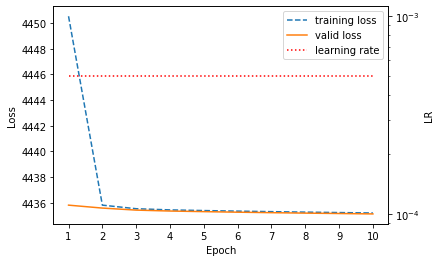

In [7]:
plot_losses(mre, save_name = get_ids(entry)[2])

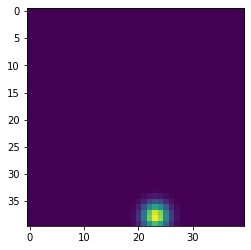

In [8]:
def get_obs(dataset, obs0_i = -1):
    obs0_i = np.random.randint(0, len(dataset)) if obs0_i == -1 else obs0_i

    obs0 = dataset[obs0_i][0]
    v0 = dataset[obs0_i][2]

    obs0['image'] = obs0['image'].unsqueeze(0).to(DEVICE, dtype = torch.float)
    v0 = v0.unsqueeze(0).to(DEVICE)

    return obs0, v0, obs0_i

def get_empty_and_full_coords(lows, highs, nmc, L):
    grid = torch.linspace(lows[0], highs[0], L+1)[:-1]
    x, y = torch.meshgrid(grid, grid, indexing = 'xy')
    m = torch.logspace(lows[-1], highs[-1], 2*nmc+1)
    m_centers, m_edges = m[1::2], m[0::2]
    ms = [torch.full((L*L,), m_i) for m_i in m_centers]

    coord_empty = torch.tensor((), device = DEVICE, dtype = torch.float).reshape(1, -1)
    coord_full = torch.cat( [torch.transpose(torch.stack((x.flatten(), y.flatten(), m)), 0, 1) for m in ms] ).reshape(1, -1).to(DEVICE, dtype = torch.float)

    return coord_empty, coord_full

obs0, v0, obs0_i = get_obs(dataset)
targets = mre.network.parameter_transform(v0).squeeze()
target = targets.numpy()
plt_imshow(obs0['image'], y = 4)

In [9]:
coord_empty, coord_full = get_empty_and_full_coords(lows, highs, nmc, L)

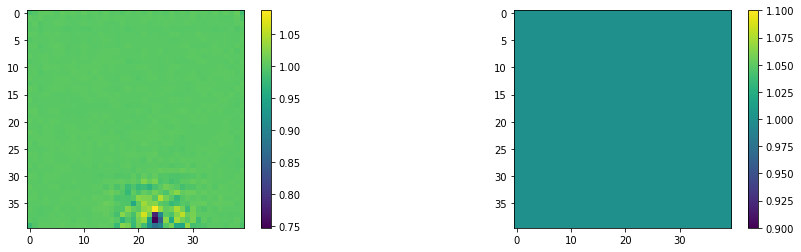

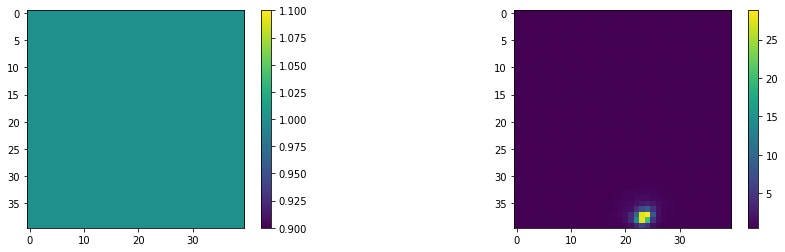

In [10]:
for coord in [coord_empty, coord_full]:
    logratio = mre.network(obs0, coord).view(nmc*2, L, L)
    plt_imshow(np.exp(logratio), cbar = True, y = 4)
#     plt_imshow(logratio, cbar = True, y = 4)